# DM-47822 : run stacking analysis for DM-49211 technote



Use the same data as for the N-donuts study. First show comparison of different methods of stacking for a single visit in an interactive mode:




## Imports

In [3]:
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astropy.time import Time
import astropy.units as u
from copy import copy
from lsst.daf.butler import Butler
from lsst.ts.wep.utils import makeDense, makeSparse, convertZernikesToPsfWidth, binArray
import matplotlib.pyplot as plt 
import numpy as np
from tqdm import tqdm
import os

## Show the impact of stacking increasing number of donuts vs  N donuts average 

We run stacking and subsequent CWFS fitting interactively for a single visit. Start from the most recently used stacking code:

In [4]:
import numpy as np
from lsst.ts.wep.estimation import WfAlgorithmFactory, WfEstimator
from lsst.ts.wep.image import Image
from lsst.ts.wep.task.estimateZernikesBase import EstimateZernikesBaseConfig
from lsst.ts.wep.task.estimateZernikesDanishTask import EstimateZernikesDanishConfig
from lsst.ts.wep.task.estimateZernikesTieTask import EstimateZernikesTieConfig
from lsst.ts.wep.utils import (
    WfAlgorithmName,
    getCameraFromButlerName,
    getTaskInstrument,
)

from lsst.daf import butler as dafButler


def stack_donut_wep_im_refactor(
    donut_stamps,
    n=2,
    indices=None,
    pixel_stack="mean",
    use_mask=False,
    replace_zeros_with_nans=True,
    after_avg_fill_with_bkgnd=True,
    use_mean_bkgnd=True,
    use_range_bkgnd=False,
    bkgnd_factor=10,
):

    stacked = {}

    if indices is None:
        indices = np.arange(n)

    else:
        n = len(indices)

    stacked["N"] = n
    stacked["indices"] = indices

    # create updated donut stamps consisting of the stacked images

    # initialize empty arrays of the correct dimension
    image_stack = []
    bkgnd_stack = []

    # add donut image arrays, store the x,y
    xs = []
    ys = []

    j = 0
    for i in indices:
        # print(f'stacking {i}')
        stamp = donut_stamps[i]
        image = stamp.stamp_im.image.array

        if use_mask:
            # has values like 0, 1024,  2048 etc
            mask = stamp.stamp_im.mask.array
            binary_mask = np.array(mask > 0).astype(int)  # has values 0 or 1
            arr = image * binary_mask
            if replace_zeros_with_nans:
                arr[arr == 0] = np.nan  # replace zeros with NaNs
        else:
            arr = image

        image_stack.append(arr)
        bkgnd_stack.append(image)

        # that already transposes each field angle ...
        fieldxy = stamp.calcFieldXY()[::-1]
        xs.append(fieldxy[0])
        ys.append(fieldxy[1])

        j += 1

        # print('stacked: ', indices)
        # store the original fieldXY
        stacked["fieldX"] = xs
        stacked["fieldY"] = ys

    # store the stacked image
    if pixel_stack == "sum":
        donut_stacked_array = np.sum(image_stack, axis=0)
    elif pixel_stack == "mean":
        donut_stacked_array = np.mean(image_stack, axis=0)
    elif pixel_stack == "nanmean":
        donut_stacked_array = np.nanmean(image_stack, axis=0)
        
    # Calculate the mean background    
    bkgnd_mean = np.nanmean(bkgnd_stack, axis=0)

    # replace np.nan with mean background...
    if use_mask and after_avg_fill_with_bkgnd:
        mask_nans = np.isnan(donut_stacked_array)
        if use_mean_bkgnd:
            donut_stacked_array[mask_nans] = bkgnd_mean[mask_nans]
            stacked["bkgnd"] = bkgnd_mean
        elif use_range_bkgnd:

            # change interval (0,1) to (-0.5,0.5) , and increase by a
            # factor to very small value or larger one
            size = np.shape(donut_stacked_array)
            bkgnd = bkgnd_factor * (np.random.random_sample(size=size) - 0.5)
            print(
                f"adding background in range {min(np.ravel(bkgnd))}\
to {max(np.ravel(bkgnd))}"
            )
            stacked["bkgnd"] = bkgnd
            donut_stacked_array[mask_nans] = bkgnd[mask_nans]

    stacked["donutStackedArray"] = donut_stacked_array

    # find the midpoint fieldXY coordinates
    # average in the same way x and y coordinates
    # for the intra and extra donut alike
    # treat them as already transposed
    stacked["fieldXmean"] = np.mean(xs)
    stacked["fieldYmean"] = np.mean(ys)

    # store information on how pixels were combined
    stacked["pixelStack"] = pixel_stack

    # part of _setWepImage(self):
    """Return a ts.wep.image.Image object for the stamp.

    Note that the information from the butler is in the data visualization
    coordinate system (DVCS), but the WEP Image is in the global camera
    coordinate system (CCS). These coordinate systems are related by a
    transpose. See sitcomtn-003.lsst.io for more information.

    Furthermore, CWFS images that arrive from the butler are rotated with
    respect to the science sensors. The info in the WEP Images has been
    de-rotated so that everything aligns with the global coordinate system
    used by the science sensors.
    """
    # both the camera name and the detector would be all
    # identical for all stamps in here ,
    # hence it would be the same Euler angle

    # stamp.cam_name  yields eg. LSSTCam;
    # taking it from the stamp
    # allows to stack also images from LSSTComCam,  or FAM ...
    camera = getCameraFromButlerName(stamp.cam_name)

    detector = camera.get(stamp.detector_name)

    # Get the rotation with respect to the science sensors
    eulerz = -detector.getOrientation().getYaw().asDegrees()
    nrot = int(eulerz // 90)
    if not np.isclose(eulerz % 90, 0):
        raise RuntimeError(
            f"The detector is rotated {-eulerz} deg with respect to the science "
            "sensors, but _setWepImage() only works for sensors whose rotations "
            "are an integer multiple of 90 deg."
        )

    # Rotate to orientation of science sensors
    image = np.rot90(donut_stacked_array, nrot)

    # Transpose the image (DVCS -> CCS)
    image = image.T

    # Get the field angle, and transpose (DVCS -> CCS)
    # fieldAngle = stamp.calcFieldXY()
    # the x,y are already a transpose of calcFieldXY() above
    fieldangle = (stacked["fieldXmean"], stacked["fieldYmean"])

    # Determine the blend offsets
    if stamp.blend_centroid_positions.size > 0:
        # Get the offsets in the original pixel coordinates
        blendoffsets = stamp.blend_centroid_positions - stamp.centroid_position

        # Rotate the coordinates (by -90 each time)
        # to match the science sensors
        rotmat = np.array([[0, 1], [-1, 0]])
        if stamp.defocal_type == "extra":
            rotmat = np.linalg.matrix_power(rotmat, nrot + 2)
        else:
            rotmat = np.linalg.matrix_power(rotmat, nrot)
        blendoffsets = np.transpose(rotmat @ blendoffsets.T)

    else:
        blendoffsets = None

    # Package everything in an Image object
    wepimage = Image(
        image=image,
        fieldAngle=fieldangle,
        defocalType=stamp.defocal_type,
        bandLabel=stamp.bandpass,
        blendOffsets=blendoffsets,
    )

    stacked["wep_im"] = wepimage

    return stacked

Get the datarefs for the visits that were selected for the N-donuts study as having multiple donuts per detector

In [15]:
Nvisits = 1269
path_cwd = os.getcwd()
fname = os.path.join(path_cwd, f'u_scichris_aosBaseline_tie_danish_zernikes_tables_{Nvisits}.npy')
results_visit = np.load(fname, allow_pickle=True).item()


fname = os.path.join(path_cwd, 'u_scichris_aosBaseline_danish1_donutQualityTable_N_donuts_all_det_select_good_new.txt')
donutQualityTableSel = Table.read(fname, format='ascii')


In [16]:
visit = 2024112700254
m = donutQualityTableSel['visit'] == visit
donutQualityTableSel[m]

Ndonuts,NdonutsIntra,NdonutsExtra,visit,detector
float64,float64,float64,int64,int64
28.0,13.0,15.0,2024112700254,2
29.0,15.0,14.0,2024112700254,5
32.0,16.0,16.0,2024112700254,4
34.0,18.0,16.0,2024112700254,7
32.0,17.0,15.0,2024112700254,3
54.0,28.0,26.0,2024112700254,1
33.0,17.0,16.0,2024112700254,0
24.0,12.0,12.0,2024112700254,6
33.0,17.0,16.0,2024112700254,8


Preview these donuts:

In [17]:
visit = 2024112700254
butler = Butler('/repo/main') 
refs = butler.query_datasets('donutStampsExtra', collections = ['u/brycek/aosBaseline_step1a'],
                            where=f"instrument = 'LSSTComCam' and visit = {visit}"
                           )
ref = refs[0]
detector = ref.dataId['detector']

/tmp/ipykernel_11766/1612777322.py:26: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  ax_hist.legend(lines, labels=[str(i) for i in range(1,11)],


Text(0.5, 0.98, 'Extra-focal donuts for LsstComCam visit 2024112700254, det 0')

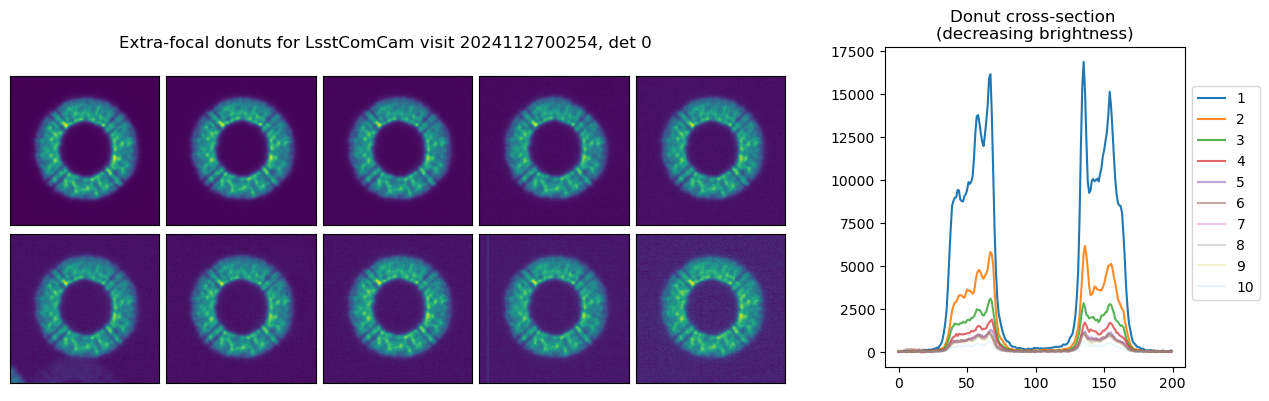

In [9]:

donutStampsExtra = butler.get('donutStampsExtra',   dataId = ref.dataId, collections=['u/brycek/aosBaseline_step1a']
                     )

# illustrate the donuts 
fig,axs = plt.subplots(2,5, figsize=(10,4))
ax_hist =  fig.add_axes([1.0,0.15,0.3,0.8])
ax = np.ravel(axs)
i=0
donutStamps = donutStampsExtra
lines = []
for stamp in donutStamps:
    if i < len(ax):
        donut = stamp.stamp_im.image.array
        ax[i].imshow(donut, origin='lower')
        ax[i].set_xticks([])
        ax[i].set_yticks([])

        # plot the cross-section
        line = ax_hist.plot(donut[:,80], alpha=1-i*0.1)
        lines.append(line)

        i += 1 

        
# add legend 
ax_hist.legend(lines, labels=[str(i) for i in range(1,11)],  
              
              bbox_to_anchor = [1,0.9])
ax_hist.set_title('Donut cross-section \n(decreasing brightness)')
fig.subplots_adjust(hspace=0.05, wspace=0.05)

if len(donutStamps)<len(ax):
    for i in range(len(donutStamps), len(ax)):
        ax[i].axis('off')
fig.suptitle(f'Extra-focal donuts for LsstComCam visit {visit}, det {detector}')

Get results for Danish/TIE. All fitted Zernikes were already saved in a table, keyed by visit / method / detector:

In [18]:
results_visit[visit]['tie1'][0][:4]

label,used,"intra_field [x, y]","extra_field [x, y]","intra_centroid [x, y]","extra_centroid [x, y]",intra_mag,extra_mag,intra_sn,extra_sn,intra_entropy,extra_entropy,intra_frac_bad_pix,extra_frac_bad_pix,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z20,Z21,Z22,Z27,Z28
,,deg,deg,pix,pix,,,,,,,,,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm
str7,bool,"(float32, float32)","(float32, float32)","(float32, float32)","(float32, float32)",float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
average,True,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)",nan,nan,nan,nan,nan,nan,0.0,0.0,-520.055419921875,-451.2308654785156,895.52587890625,-85.60143280029297,35.85567092895508,32.08739471435547,149.96958923339844,252.3431396484375,32.0811653137207,75.34446716308594,94.40440368652344,-76.37826538085938,-33.87873077392578,38.04983901977539,-7.052538871765137,34.818145751953125,-35.3137321472168
pair1,True,"(-0.2308646, -0.22396731)","(-0.23064193, -0.2236334)","(2111.0, 2199.0)","(2115.0, 2205.0)",nan,nan,9998.902,9706.954,0.88309836,0.9171697,0.0,0.0,-538.7452392578125,-404.3611755371094,860.7077026367188,-6.959954738616943,28.776145935058594,-7.641102313995361,163.1453399658203,262.0345764160156,26.092262268066406,77.85328674316406,101.83341979980469,-87.58312225341797,-30.727540969848633,42.384925842285156,-6.829599857330322,31.62855339050293,-31.028507232666016
pair2,True,"(-0.2015259, -0.14724432)","(-0.2014146, -0.14702182)","(2638.0, 3578.0)","(2640.0, 3582.0)",nan,nan,5832.709,5602.5117,1.0257335,0.99612826,1e-04,1e-04,-478.5666198730469,-299.8625793457031,838.6546020507812,-82.10179901123047,44.04525375366211,-47.71973419189453,188.94419860839844,257.1624755859375,20.487009048461914,47.786380767822266,94.91815948486328,-87.44808959960938,-42.81656265258789,38.684478759765625,-4.4673004150390625,40.31049728393555,-43.01108932495117
pair3,True,"(-0.2510318, -0.28552258)","(-0.250809, -0.28513286)","(1749.0, 1093.0)","(1753.0, 1100.0)",nan,nan,4067.327,3918.3132,1.5115595,1.5009215,0.0002,0.000125,-550.8101806640625,-610.99365234375,949.0415649414062,-155.77267456054688,-51.76531219482422,105.29337310791016,130.18310546875,248.2414093017578,40.3558349609375,87.6579360961914,114.40593719482422,-74.4631118774414,-37.043697357177734,32.25072479248047,-7.788902282714844,37.92119598388672,-19.413070678710938


Run stacking for that visit. Illustrate various approaches to stacking: what does it look like to stack increasing number of donuts?

1 0.1
2 0.2
3 0.30000000000000004
4 0.4
5 0.5
6 0.6000000000000001
7 0.7000000000000001
8 0.8
9 0.9
10 1.0
1 0.1
2 0.2
3 0.30000000000000004
4 0.4
5 0.5
6 0.6000000000000001
7 0.7000000000000001
8 0.8
9 0.9
10 1.0
1 0.1
2 0.2
3 0.30000000000000004
4 0.4
5 0.5
6 0.6000000000000001
7 0.7000000000000001
8 0.8
9 0.9
10 1.0


/tmp/ipykernel_57943/2216970908.py:37: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  ax_hist.legend(lines, labels=[str(n) for n in range(1,11)],
/tmp/ipykernel_57943/3016897281.py:87: RuntimeWarning: Mean of empty slice
  donut_stacked_array = np.nanmean(image_stack, axis=0)


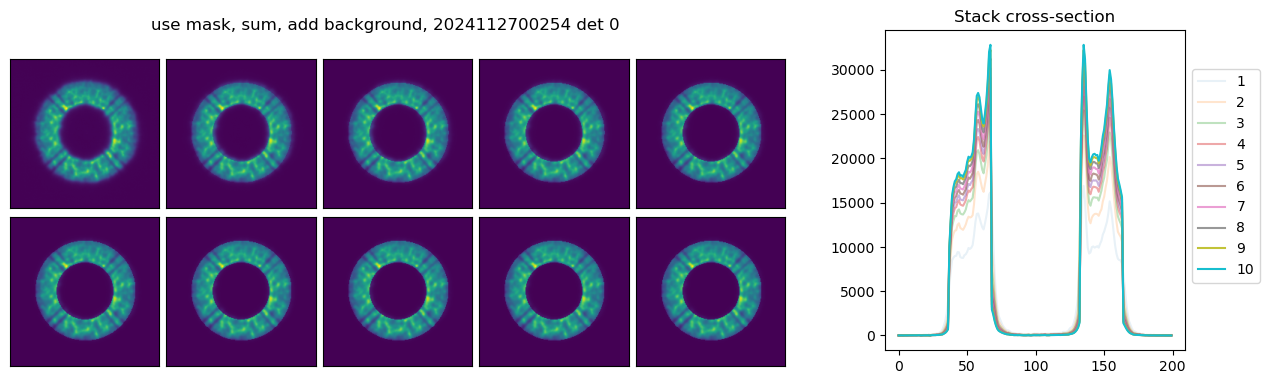

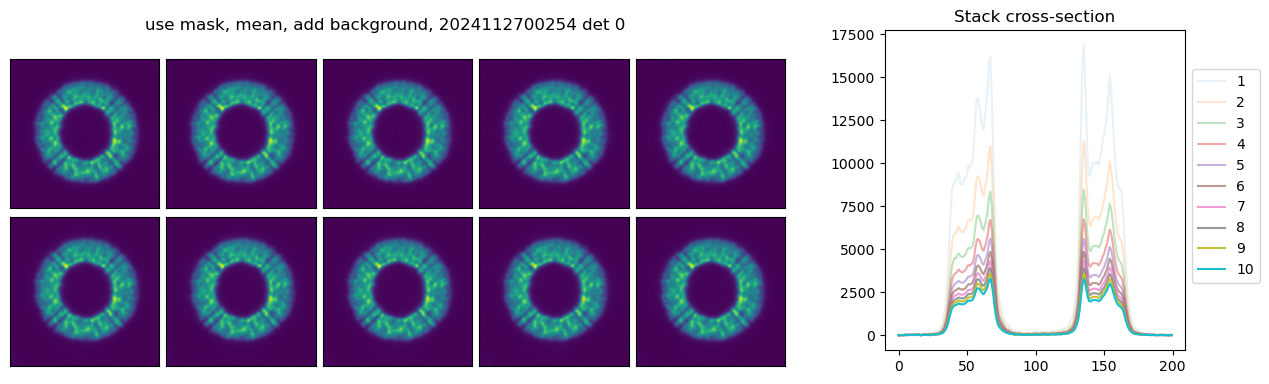

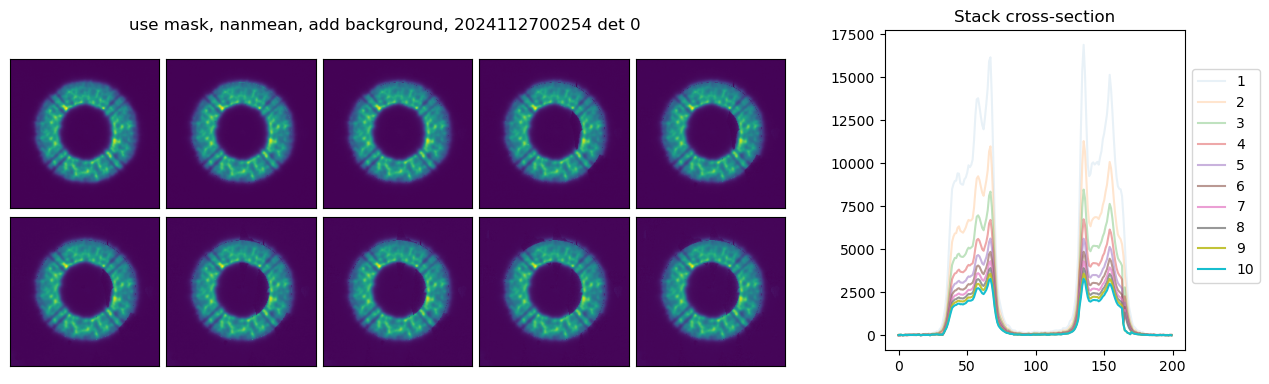

In [72]:
# illustrate the donuts 


use_mask = True
add_bkgnd = True
for pixel_stack in ['sum', 'mean', 'nanmean']:

    fig,axs = plt.subplots(2,5, figsize=(10,4))
    ax = np.ravel(axs)
    ax_hist =  fig.add_axes([1.0,0.15,0.3,0.8])
    i = 0 
    lines = []
    for n in range(1,11):
        
        stackedExtra = stack_donut_wep_im_refactor(
            donutStampsExtra,
            n=n,
            pixel_stack=pixel_stack,
            use_mask=use_mask,
            after_avg_fill_with_bkgnd=add_bkgnd,
        )
        mask_string = "use" if use_mask else "no"
        background_string = "add" if add_bkgnd else "no"
        if i < len(ax):
            
    
    
            ax[i].imshow(stackedExtra['donutStackedArray'], origin='lower')
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            i += 1 
    
        # plot the cross-section
        line = ax_hist.plot(stackedExtra['donutStackedArray'][:,80], alpha=n*0.1)
        print(n, 0.1*n)
        lines.append(line)
    ax_hist.legend(lines, labels=[str(n) for n in range(1,11)], 
             bbox_to_anchor = [1,0.9])
    ax_hist.set_title('Stack cross-section')
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    
    
    if len(donutStamps)<len(ax):
        for i in range(len(donutStamps), len(ax)):
            ax[i].axis('off')
    fig.suptitle(f"{mask_string} mask, {pixel_stack}, {background_string} background, {visit} det {detector}")


In the above example, with `mean` and `nanmean` the stacked pixel count decreases, because we are adding progressively fainter donuts to the average. 

Illustrate difference between using mask and not using the mask. We only plot a fragment of each donut to highlight the differences:

/tmp/ipykernel_57943/3016897281.py:87: RuntimeWarning: Mean of empty slice
  donut_stacked_array = np.nanmean(image_stack, axis=0)
/tmp/ipykernel_57943/1635976646.py:41: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  ax_hist.legend(lines, labels=[str(n) for n in range(1,11)],


1 0.1
2 0.2
3 0.30000000000000004
4 0.4
5 0.5
6 0.6000000000000001
7 0.7000000000000001
8 0.8
9 0.9
10 1.0
1 0.1
2 0.2
3 0.30000000000000004
4 0.4
5 0.5
6 0.6000000000000001
7 0.7000000000000001
8 0.8
9 0.9
10 1.0


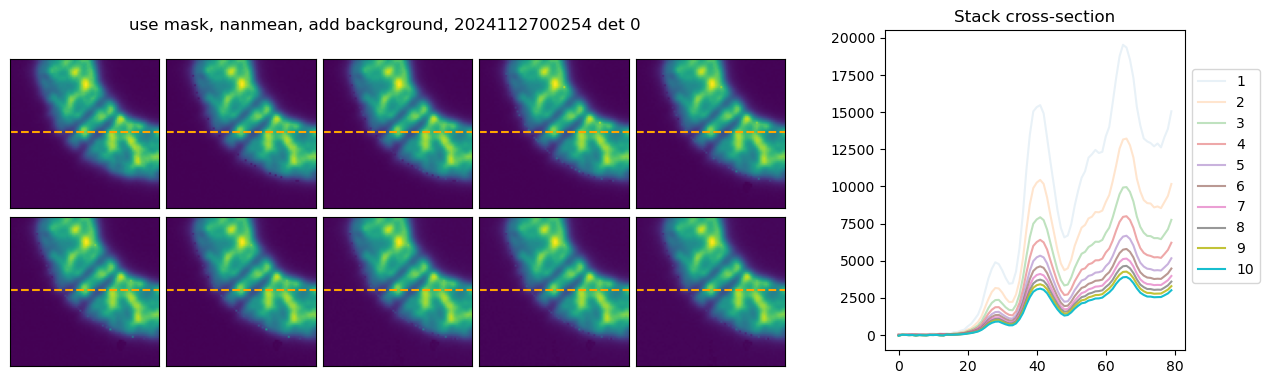

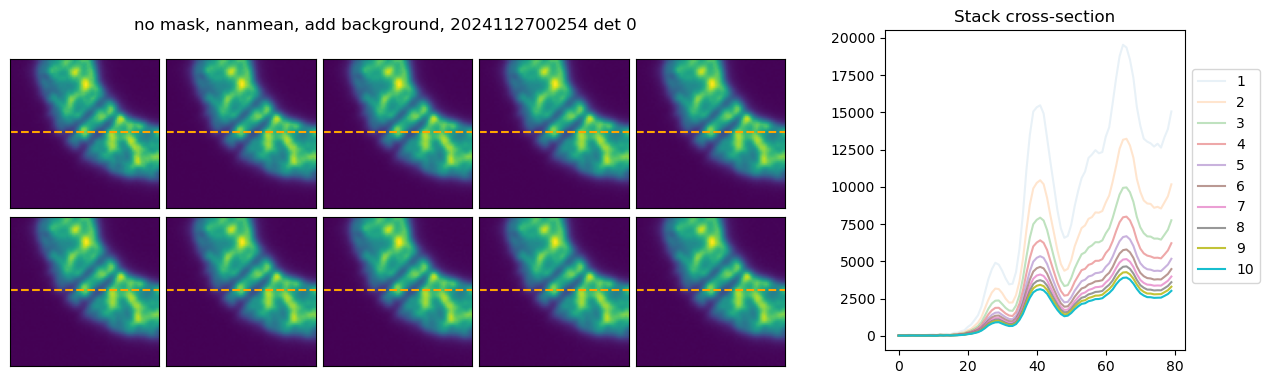

In [98]:
# illustrate the donuts 

add_bkgnd = True
pixel_stack = "nanmean"
for use_mask in [True, False]:

    fig,axs = plt.subplots(2,5, figsize=(10,4))
    ax = np.ravel(axs)
    ax_hist =  fig.add_axes([1.0,0.15,0.3,0.8])
    i = 0 
    lines = []
    for n in range(1,11):
        
        stackedExtra = stack_donut_wep_im_refactor(
            donutStampsExtra,
            n=n,
            pixel_stack=pixel_stack,
            use_mask=use_mask,
            after_avg_fill_with_bkgnd=add_bkgnd,
        )
        mask_string = "use" if use_mask else "no"
        background_string = "add" if add_bkgnd else "no"
        if i < len(ax):
            
    
            xmin,xmax = 20,100
            ymin,ymax = xmin,xmax
            ycross = (ymin+ymax)//2
            ax[i].imshow(stackedExtra['donutStackedArray'][20:100, 20:100], origin='lower',)
                        # cmap='Grays_r')
            ax[i].axhline(ycross-ymin, c='orange', ls='--')
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            i += 1 
    
        # plot the cross-section
        
        line = ax_hist.plot(stackedExtra['donutStackedArray'][xmin:xmax, ycross], alpha=n*0.1)
        print(n, 0.1*n)
        lines.append(line)
    ax_hist.legend(lines, labels=[str(n) for n in range(1,11)], 
             bbox_to_anchor = [1,0.9])
    ax_hist.set_title('Stack cross-section')
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    
    
    if len(donutStamps)<len(ax):
        for i in range(len(donutStamps), len(ax)):
            ax[i].axis('off')
    fig.suptitle(f"{mask_string} mask, {pixel_stack}, {background_string} background, {visit} det {detector}")


Compare the results for a single visit / detector,  stacking increasing number of donuts 

In [10]:
import numpy as np
from lsst.ts.wep.estimation import WfAlgorithmFactory, WfEstimator
from lsst.ts.wep.image import Image
from lsst.ts.wep.task.estimateZernikesBase import EstimateZernikesBaseConfig
from lsst.ts.wep.task.estimateZernikesDanishTask import EstimateZernikesDanishConfig
from lsst.ts.wep.task.estimateZernikesTieTask import EstimateZernikesTieConfig
from lsst.ts.wep.utils import (
    WfAlgorithmName,
    getCameraFromButlerName,
    getTaskInstrument,
)

from lsst.daf import butler as dafButler

print(f"Reading visit {visit}, det {detector} ")

stamp_collection = 'u/brycek/aosBaseline_step1a'
stamps_extra = butler.get(
    "donutStampsExtra", dataId=ref.dataId, collections=[stamp_collection]
)
stamps_intra = butler.get(
    "donutStampsIntra", dataId=ref.dataId, collections=[stamp_collection]
)

# Initialize WEP following calcZernikes =-> estimateZernikes

# read the camera and detector from the extra-focal donut, since
# the instrument would be the same for all
cam_name = stamps_extra[0].cam_name
detector_name = stamps_extra[0].detector_name

instrument = getTaskInstrument(
    cam_name,
    detector_name,
    None,
)


Reading visit 2024112700254, det 0 


In [12]:
def fit_donuts(stamps_extra,stamps_intra, instrument,zk_modes, NdonutsToAverage=10,pixel_stack="nanmean"):

    # Use these the same for all other settings
    NdonutsToAverage = 10 
    pixel_stack = "nanmean"
    
    stacking_results = {}
    
    for method in ['tie', 'danish']:
        for use_mask in [True, False]:
            for add_bkgnd in [True,]:
                estimateZernikesBaseConfig = EstimateZernikesBaseConfig()
                
                if method == "danish":
                    wfAlgoName = WfAlgorithmName.Danish
                    estimateZkConfig = EstimateZernikesDanishConfig()
                elif method == "tie":
                    wfAlgoName = WfAlgorithmName.TIE
                    estimateZkConfig = EstimateZernikesTieConfig()
                
                
                algoConfig = {
                    key: val
                    for key, val in estimateZkConfig.toDict().items()
                    if key not in estimateZernikesBaseConfig._fields.keys()
                }
                wfAlgoConfig = WfAlgorithmFactory.createWfAlgorithm(wfAlgoName, algoConfig)
                
                # Create the wavefront estimator
                wfEst = WfEstimator(
                    algoName=wfAlgoName,
                    algoConfig=wfAlgoConfig,
                    instConfig=instrument,
                    nollIndices=zk_modes # use the same as what was used in pairing analysis
                )
                
                # take the mean defocal offset from the first donut in each
                # detector; this would be the same for all donuts
                donut_extra = stamps_extra[0]
                donut_intra = stamps_intra[0]
                # the mean defocal offset would be the same for all considered donuts
                defocalOffset = np.mean(
                    [
                        donut_extra.defocal_distance,
                        donut_intra.defocal_distance,
                    ]
                )
                # print(state, raft, defocalOffset)
                wfEst.instrument.defocalOffset = defocalOffset / 1e3  # m -> mm
        
                
                mask_string = "use" if use_mask else "no"
                background_string = "add" if add_bkgnd else "no"
                
                # stack donuts and estimate as well
                stackedExtra = stack_donut_wep_im_refactor(
                    stamps_extra,
                    n=NdonutsToAverage,
                    pixel_stack=pixel_stack,
                    use_mask=use_mask,
                    after_avg_fill_with_bkgnd=add_bkgnd,
                )
                
                stackedIntra = stack_donut_wep_im_refactor(
                    stamps_intra,
                    n=NdonutsToAverage,
                    pixel_stack=pixel_stack,
                    use_mask=use_mask,
                    after_avg_fill_with_bkgnd=add_bkgnd,
                )
                method_string  = f"stacking_{method}_{mask_string}_mask_{background_string}_bkgnd"
                
                if method == 'danish' and use_mask and not add_bkgnd:
                    print(f"Not fitting {method_string} due to instabilities for Danish with empty background")
                    continue
                else:
                    print(f"Fitting {method_string}")
                    # these are in microns
                    zkst = wfEst.estimateZk(stackedExtra["wep_im"], stackedIntra["wep_im"])
    
                    stacking_results[method_string] = zkst
    return stacking_results

In [13]:
stacking_results = fit_donuts(stamps_extra,stamps_intra, instrument,NdonutsToAverage=10,pixel_stack="nanmean") 

NameError: name 'zk_modes' is not defined

Compare the results to averaging N donuts: 

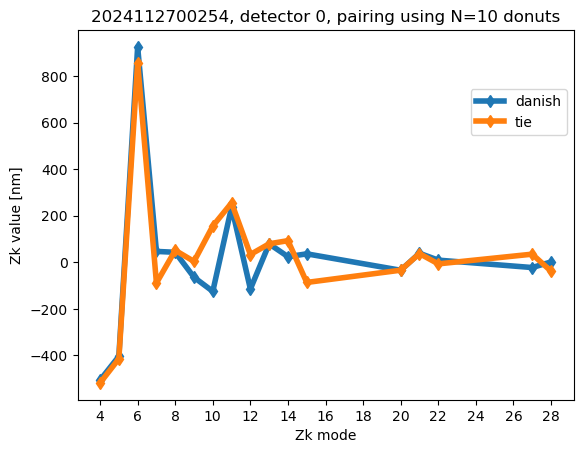

In [170]:
fig,ax  = plt.subplots(1,1,)

NdonutsToAverage = 10 

Nmin=1 # the 0th row is the average of all used donuts, i.e. probably more than 0 in this experiment
Nmax = Nmin+NdonutsToAverage 

for method in ['danish', 'tie']:
    zernikes_all = results_visit[visit][f'{method}1'][detector]
    
    # select only those zernikes that were actually used 
    zernikes = zernikes_all[zernikes_all['used'] == True]
    zk_cols = [col for col in zernikes.columns if col.startswith('Z')]
    zk_modes = [int(col[1:]) for col in zk_cols]
    
    # Calculate the final average of N donut pairs 
    rows = zernikes[Nmin:Nmax]
    zk_fit_nm_avg  = [np.median(rows[col].value) for col in zk_cols]
    ax.plot(zk_modes,  np.array(zk_fit_nm_avg), marker='d', label=f'{method}', lw=4)
    
# for method_string in stacking_results.keys():
#     # stacking results are in microns - convert to nanometers
#     ax.plot(zk_modes, stacking_results[method_string]*1000, label=method_string)
ax.set_title(f"{visit}, detector {detector}, pairing using N={NdonutsToAverage} donuts")
ax.set_xticks(np.arange(4,29,step=2))
ax.set_xlabel( 'Zk mode')
ax.set_ylabel(  'Zk value [nm]', rotation='vertical')
ax.legend(bbox_to_anchor=[1.0,0.86])

Compare pairing to stacking within each method: 

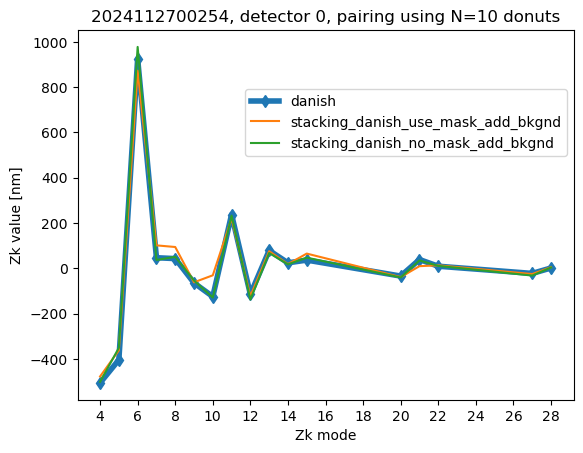

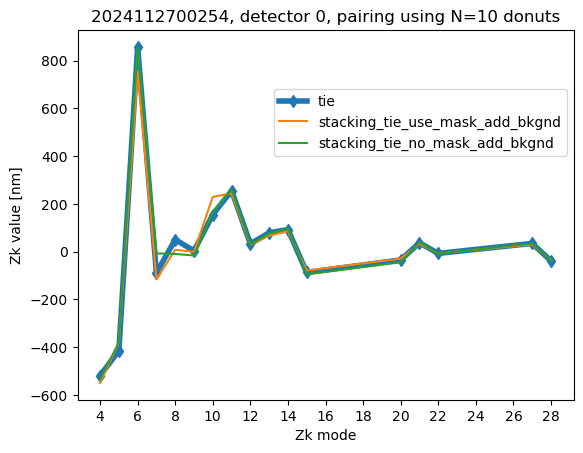

In [171]:


NdonutsToAverage = 10 

Nmin=1 # the 0th row is the average of all used donuts, i.e. probably more than 0 in this experiment
Nmax = Nmin+NdonutsToAverage 

for method in ['danish', 'tie']:
    fig,ax  = plt.subplots(1,1,)
    
    zernikes_all = results_visit[visit][f'{method}1'][detector]
    
    # select only those zernikes that were actually used 
    zernikes = zernikes_all[zernikes_all['used'] == True]
    zk_cols = [col for col in zernikes.columns if col.startswith('Z')]
    zk_modes = [int(col[1:]) for col in zk_cols]
    
    # Calculate the final average of N donut pairs 
    rows = zernikes[Nmin:Nmax]
    zk_fit_nm_avg  = [np.median(rows[col].value) for col in zk_cols]
    ax.plot(zk_modes,  np.array(zk_fit_nm_avg), marker='d', label=f'{method}', lw=4)
    
    for method_string in stacking_results.keys():
        if method in method_string:
            # stacking results are in microns - convert to nanometers
            ax.plot(zk_modes, stacking_results[method_string]*1000, label=method_string)
    ax.set_title(f"{visit}, detector {detector}, pairing using N={NdonutsToAverage} donuts")
    ax.set_xticks(np.arange(4,29,step=2))
    ax.set_xlabel( 'Zk mode')
    ax.set_ylabel(  'Zk value [nm]', rotation='vertical')
    ax.legend(bbox_to_anchor=[1.0,0.86])

We see that in that particular case, stacking results follow pairing very closely. Consider how this is changed as we use different number of averaged donut pairs:

In [ ]:
wep_collection = 'u/scichris/aosBaseline_danish_binning_1'
refs = butler.query_datasets('zernikes',  collections=[wep_collection], limit=1)
donutQualityTable = butler.get('donutQualityTable', dataId=refs[0].dataId, collections=[wep_collection]) 